# Histogram equalization

---

In [1]:
import numpy as np
from datasets.dataloader import *

loader,target_loader=get_train_loader("./data/processed/R/","./data/processed/V/",resize=256)
next(iter(loader)).shape

/home/poong/yes/envs/naf/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libc10_cuda.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


torch.Size([8, 3, 256, 256])

In [4]:
from datasets.dataloader import *

test_images = get_test_loader(root="./data/processed/R", batch_size=8, shuffle=False,resize=256)
image_batch= next(iter(test_images))

In [35]:
from PIL import Image
import numpy as np
import glob
path=glob.glob("./data/processed/R/*.jpg")
path_V=glob.glob("./data/processed/V/*.jpg")
base_shape=np.array(Image.open(path[0])).shape
for pa in path_V:
    im=Image.open(pa)
    if np.array(im).shape!=base_shape:
        print("except_size")
        print(pa)
        print(np.array(im).shape)
        


In [33]:
np.array(Image.open("./data/processed/R/R02893.jpg")).shape

(1250, 2660, 3)

In [9]:
from models.base_model import Resizing_Generator
import torch.nn as nn
from models import load_Generator,load_Discriminator


import torch
noise=torch.normal(0,1,size=(1,3,256,256))
model=Resizing_Generator(n_res=6)
model(noise).shape

torch.Size([1, 3, 256, 256])

In [5]:
from torchsummary import summary as summary
summary(model,(3,310,650))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 306, 646]           9,408
       BatchNorm2d-2         [-1, 64, 306, 646]             128
         LeakyReLU-3         [-1, 64, 306, 646]               0
            Conv2d-4        [-1, 128, 153, 323]          73,728
       BatchNorm2d-5        [-1, 128, 153, 323]             256
         LeakyReLU-6        [-1, 128, 153, 323]               0
            Conv2d-7         [-1, 256, 77, 162]         294,912
       BatchNorm2d-8         [-1, 256, 77, 162]             512
         LeakyReLU-9         [-1, 256, 77, 162]               0
           Conv2d-10         [-1, 256, 77, 162]         589,824
   InstanceNorm2d-11         [-1, 256, 77, 162]             512
        LeakyReLU-12         [-1, 256, 77, 162]               0
        LeakyReLU-13         [-1, 256, 77, 162]               0
        LeakyReLU-14         [-1, 256, 

In [2]:
from models.block import *

class Generator_Mod(nn.Module):
    def __init__(self,n_res=4,use_bias=False):
        super().__init__()
        
        self.n_res=n_res
        self.use_bias=use_bias
        self.down_sampling=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=7,stride=1,padding=0,bias=use_bias),
            nn.BatchNorm2d(64,affine=True),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64,128,kernel_size=3,stride=2,padding=3,bias=use_bias),
            nn.BatchNorm2d(128,affine=True),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(128,256,kernel_size=3,stride=2,padding=1,bias=use_bias),
            nn.BatchNorm2d(256,affine=True),
            nn.LeakyReLU(0.2,inplace=True),
        )
        
        res_block=[]
        for i in range(n_res):
            res_block.append(ResBlk(256,256,normalize=True,use_bias=self.use_bias))
        self.res_block=nn.Sequential(*res_block)
        
        self.up_sampling = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=0, output_padding=1, bias=use_bias),
            nn.BatchNorm2d(128,affine=True),
            nn.LeakyReLU(0.2,inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0, output_padding=1, bias=use_bias),
            nn.BatchNorm2d(64,affine=True),
            nn.LeakyReLU(0.2,inplace=True),

            nn.Conv2d(64, 3, kernel_size=7, stride=1, padding=0, bias=use_bias),
            nn.Tanh()
        )
    
    def forward(self,input):
        x=self.down_sampling(input)
        x=self.res_block(x)
        out=self.up_sampling(x)
        return out

In [3]:
import torch.nn as nn

import torch
noise=torch.normal(0,1,size=(1,3,256,256))
model=Generator_Mod()
model(noise).shape

torch.Size([1, 3, 256, 256])

In [1]:
from models.base_model import *
noise=torch.normal(0,1,size=(1,3,256,256))
D=BaseDiscriminator()
D(noise).shape


torch.Size([1, 1, 55, 55])

In [30]:
from torchsummary import summary
summary(D,(3, 310, 650))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 308, 648]           4,800
         LeakyReLU-2         [-1, 64, 308, 648]               0
            Conv2d-3        [-1, 128, 154, 324]          73,728
         LeakyReLU-4        [-1, 128, 154, 324]               0
            Conv2d-5        [-1, 128, 154, 324]         147,456
       BatchNorm2d-6        [-1, 128, 154, 324]             256
         LeakyReLU-7        [-1, 128, 154, 324]               0
            Conv2d-8         [-1, 128, 77, 162]         147,456
         LeakyReLU-9         [-1, 128, 77, 162]               0
           Conv2d-10         [-1, 256, 77, 162]         294,912
      BatchNorm2d-11         [-1, 256, 77, 162]             512
        LeakyReLU-12         [-1, 256, 77, 162]               0
           Conv2d-13          [-1, 256, 39, 81]         589,824
      BatchNorm2d-14          [-1, 256,

In [ ]:
import glob
from skimage.metrics import structural_similarity as ssim 
import cv2
R_path=glob.glob("./data/processed/R/*.jpg") 
V_path=glob.glob("./data/processed/V/*.jpg")
R_im=cv2.imread(R_path[0])
V_im=cv2.imread(V_path[0])
ssim(R_im,V_im)

In [8]:
R_im.shape

(1240, 2600, 3)

In [9]:
V_im.shape

(1240, 2500, 3)

In [4]:
import glob
import cv2
import matplotlib.pyplot as plt

R_path=glob.glob("./data/processed/R/*.jpg") 
V_path=glob.glob("./data/processed//V/*.jpg")


In [3]:
shape=cv2.imread(R_path[0]).shape
for p in R_path:
    im=cv2.imread(p)
    if shape!=im.shape:
        print(im.shape)
    

KeyboardInterrupt: 

In [5]:
im=cv2.imread(V_path[0],cv2.COLOR_RGB2GRAY)
    

In [14]:
dst=cv2.equalizeHist(im[:,:,0])

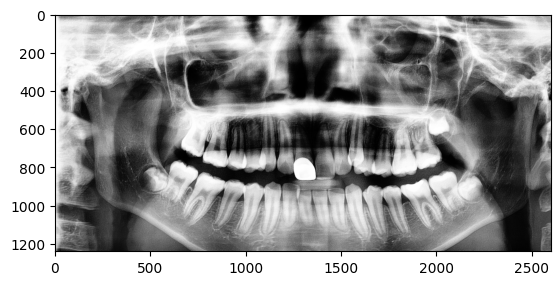

In [16]:
import matplotlib.pyplot as plt
plt.imshow(dst,cmap='gray')

In [6]:
from utils import *
get_histogram(dst)

NameError: name 'dst' is not defined

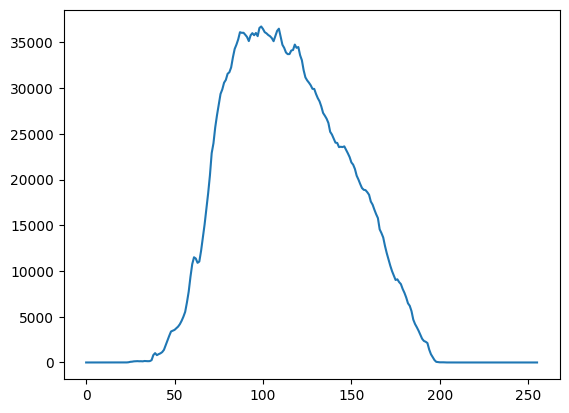

In [7]:
plt.plot(get_histogram(im))

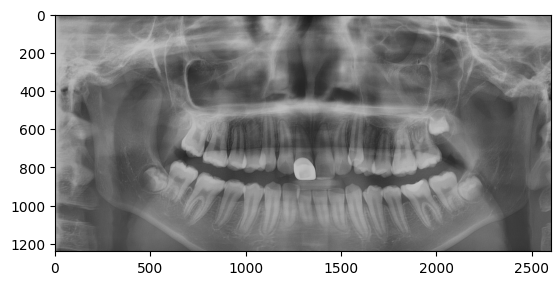

In [8]:
plt.imshow(im)